In [1]:
import os
import numpy as np
#%matplotlib inline
import matplotlib.pyplot as plt
plt.ion()

#%load_ext autoreload
#%autoreload 2
import nbodykit
import Corrfunc

from Corrfunc.theory.DDsmu import DDsmu
from Corrfunc.utils import compute_amps
from Corrfunc.utils import evaluate_xi
from Corrfunc.utils import qq_analytic
from Corrfunc.bases import bao

# Iterative BAO on Theory Data

### Set up parameters

Here we use a high-density lognormal simulation box, because we'll be able to compute the QQ term analytically.

In [2]:
boxsize = 750
nbar_str = '1e-4'

rmin = 40
rmax = 200
nbins = 16

mumax = 1.0
seed = 0
#weight_type='pair_product'
weight_type=None

In [3]:
rbins = np.linspace(rmin, rmax, nbins+1)
rbins_avg = 0.5*(rbins[1:]+rbins[:-1])
rcont = np.linspace(rmin, rmax, 1000)

cat_tag = '_L{}_nbar{}'.format(boxsize, nbar_str)
cat_dir = '../byebyebias/catalogs/cats_lognormal{}'.format(cat_tag)

periodic = True
nthreads = 24
nmubins = 1
verbose = False

### Load in data

In [4]:
# data
data_fn = '{}/cat_lognormal{}_seed{}.dat'.format(cat_dir, cat_tag, seed)
data = np.loadtxt(data_fn)
x, y, z = data.T
nd = data.shape[0]
#weights = np.full(nd, 0.5)
weights = None

In [5]:
# randoms
rand_fn = '{}/rand{}_10x.dat'.format(cat_dir, cat_tag)
random = np.loadtxt(rand_fn)
x_rand, y_rand, z_rand = random.T
nr = random.shape[0]
#weights_rand = np.full(nr, 0.5)
weights_rand = None

In [6]:
print(nd)
print(nd*(nd-1))
print(nd*nd)

print(nd/(750.**3))

42138
1775568906
1775611044
9.988266666666667e-05


Input CF:

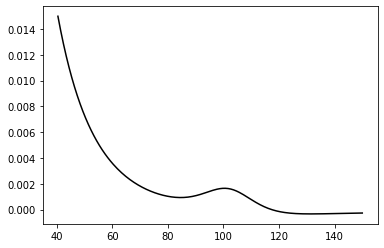

In [7]:
plt.figure()
r_true, xi_true, _ = np.load('{}/cf_lin_true{}.npy'.format(cat_dir, cat_tag), allow_pickle=True, encoding='latin1')
xi_true = [xi_true[i] for i in range(len(r_true)) if rmin<=r_true[i]<rmax]
r_true = [r_true[i] for i in range(len(r_true)) if rmin<=r_true[i]<rmax]
plt.plot(r_true, xi_true, color='k')

## BAO basis

In [8]:
base_colors = ['magenta', 'red', 'orange', 'green', 'blue']
base_names = ['a1', 'a2', 'a3', 'Bsq', 'C']

Check out basis functions:

In [13]:
def plot_bases(bases):
    plt.figure()
    bases.shape
    r = bases[:,0]
    for i in range(len(bases[0])-1):
        #norm = np.mean(bases[:,i])
        base = bases[:,i+1]
        plt.plot(r, base, color=base_colors[i], label='{}'.format(base_names[i]))
    plt.legend()
    
def run_estimator(proj_type, nprojbins, projfn):

    _, dd_proj, _ = DDsmu(1, nthreads, rbins, mumax, nmubins, x, y, z,
                    proj_type=proj_type, nprojbins=nprojbins, projfn=projfn,
                    verbose=verbose, boxsize=boxsize, periodic=periodic)
    print("DD:")
    print(dd_proj)

    
    _, dr_proj, _ = DDsmu(0, nthreads, rbins, mumax, nmubins, x, y, z,
                        X2=x_rand, Y2=y_rand, Z2=z_rand, 
                        proj_type=proj_type, nprojbins=nprojbins, projfn=projfn,
                        verbose=verbose, boxsize=boxsize, periodic=periodic)
    _, rr_proj, qq_proj = DDsmu(1, nthreads, rbins, mumax, nmubins, x_rand, y_rand, z_rand,
            proj_type=proj_type, nprojbins=nprojbins, projfn=projfn,
            verbose=verbose, boxsize=boxsize, periodic=periodic)
    print("DR RR QQ")
    print(dr_proj)
    print(rr_proj)
    print(qq_proj.reshape(nprojbins, nprojbins))
    
    volume = float(boxsize**3)
    sbins = rbins
    nsbins = len(rbins)-1
    rr_ana, qq_ana = qq_analytic(rmin, rmax, nd, volume, nprojbins, nsbins, sbins, proj_type, projfn=projfn)
    print("QQ ANA")
    print(qq_ana)
    #dd = dd_proj*2.0/float(nd*(nd-1))
    dd = dd_proj / float(nd*(nd-1))
    dr = dr_proj / float(nd*nr)
    rr = rr_proj / float(nr*(nr-1))
    numerator = dd-2*dr+rr
    #numerator = dd
    print('numerator')
    print(numerator)
    print('dd:', dd)
    qq_try = qq_ana/float(nd*(nd-1))
    print("QQ TRY")
    # the factor of 100 must be (nr/nd)**2 - nd goes into qq, nr goes into rr by construction
    print(qq_try)
    amps_periodic_ana = np.matmul(np.linalg.inv(qq_try), numerator)
    #amps_periodic_ana = np.matmul(np.linalg.inv(qq_ana), dd_proj) - 1
    xi_periodic_ana = evaluate_xi(nprojbins, amps_periodic_ana, len(rcont), rcont, len(rbins)-1, rbins, proj_type, projfn=projfn)
    print("amps per:", amps_periodic_ana)        
    qq_test = qq_ana.flatten() * 10**2
    print("QQ test")
    print(qq_test)
    amps_test = compute_amps(nprojbins, nd, nd, nr, nr, dd_proj, dr_proj, dr_proj, rr_proj, qq_test)
    print("amps test:", amps_test)
    amps = compute_amps(nprojbins, nd, nd, nr, nr, dd_proj, dr_proj, dr_proj, rr_proj, qq_proj)
    print("amps regular:", amps)
    xi_proj = evaluate_xi(nprojbins, amps_test, len(rcont), rcont, len(rbins)-1, rbins, proj_type, projfn=projfn)
        
    return amps_periodic_ana, xi_periodic_ana
    #return amps_test, xi_proj

def plot_bao(bases, amps):
    plt.figure()
    total = np.zeros(len(bases))
    r = bases[:,0]
    for i in range(0, bases.shape[1]-1):
        ampbase =  amps[i]*bases[:,i+1]
        total += ampbase
        plt.plot(rcont, ampbase, color=base_colors[i], label='{} = {:.4f}'.format(base_names[i], amps[i]))
    plt.plot(r, total, color='purple', label='total', lw=3, ls='-.')
    #plt.plot(r_true, xi_true, color='k')
    plt.xlabel(r'$r (h^{-1}Mpc)$')
    plt.ylabel(r'$\xi(r)$')
    plt.xlim(rmin, rmax)
    plt.legend()
    
def bao_iterative(dalpha, alpha_model):

    proj_type = 'generalr'
    projfn = 'bao.dat'
    # The spline routine writes to file, so remember to delete later
    kwargs = {'cosmo_base':nbodykit.cosmology.Planck15, 'redshift':0, 'dalpha':dalpha, 'alpha_model':alpha_model}
    nprojbins, _ = bao.write_bases(rbins[0], rbins[-1], projfn, **kwargs)
    bases = np.loadtxt(projfn)
    
    #plot_bases(bases)
    
    amps, xi = run_estimator(proj_type, nprojbins, projfn)
    
    plot_bao(bases, amps)
    
    return amps

dalpha: 0.01, alpha_model: 1.05


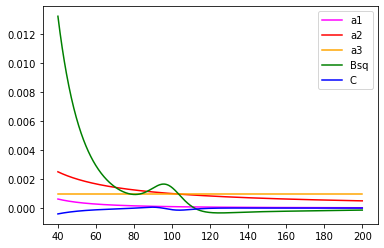

In [10]:
proj_type = 'generalr'
projfn = 'bao.dat'
# The spline routine writes to file, so remember to delete later
kwargs = {'cosmo_base':nbodykit.cosmology.Planck15, 'redshift':0, 'dalpha':0.01, 'alpha_model':1.05}
nprojbins, _ = bao.write_bases(rbins[0], rbins[-1], projfn, **kwargs)
bases = np.loadtxt(projfn)
plot_bases(bases)

dalpha: 0.0103, alpha_model: 1.03
Applying projection requires fallback method, switching instruction set
Reading in projection file, bao.dat...
Read in 1000 by 6 basis data
DD:
[  8479.10607868 101630.84538537 139933.23999997  19597.70542501
  -1618.14575088]
Applying projection requires fallback method, switching instruction set
Reading in projection file, bao.dat...
Read in 1000 by 6 basis data
Applying projection requires fallback method, switching instruction set
Reading in projection file, bao.dat...
Read in 1000 by 6 basis data
DR RR QQ
[  84545.42782496 1014555.26974668 1397840.99399139  192980.04986775
  -16072.72285924]
[  844609.78606386 10135196.50962231 13963962.3008599   1928306.63757979
  -160608.42563275]
[[  105.58005274   849.60602086   844.60978606  1034.57050314
    -40.6179437 ]
 [  849.60602086  8446.09334689 10135.19650962  5143.6625263
   -245.59930997]
 [  844.60978606 10135.19650962 13963.96230051  1928.30663758
   -160.60842563]
 [ 1034.57050314  5143.6625263

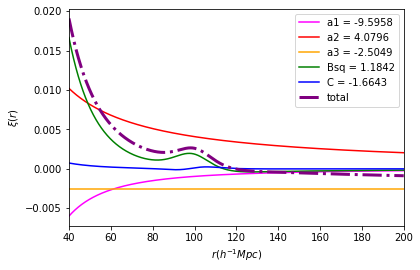

In [14]:
alpha_model = 1.03
dalpha = 0.01*alpha_model
amps = bao_iterative(dalpha, alpha_model)